![Py4Eng](img/logo.png)

# Transformers
## Yoav Ram

We will see here the Transformer architecture from [Attention Is All You Need](http://arxiv.org/abs/1706.03762), applied to timeseries instead of natural language.

**Please use the correct kernel**: in the notebook menu bar, click `Kernel`, then `Change kernel...` then choose `conda_tensorflow2_p38`.

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

import tensorflow as tf
import keras

print('Tensorflow:', tf.__version__)    
print('Keras:', keras.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

Tensorflow: 2.13.1
Keras: 2.13.1
GPU: []



# The FordA dataset

The dataset we are using here is called [_FordA_](http://www.j-wichard.de/publications/FordPaper.pdf).
The dataset contains 3601 training instances and another 1320 testing instances. Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. For this task, the goal is to automatically detect the presence of a specific issue with the engine. The problem is a balanced binary classification task. 

We will use the `FordA_TRAIN` file for training and the `FordA_TEST` file for testing. 
The first column corresponds to the label.

In [31]:
root_url = "https://github.com/yoavram/cd-diagram/raw/master/FordA/"

train_data = np.loadtxt(root_url + "FordA_TRAIN.tsv", delimiter="\t")
x_train, y_train = train_data[:, 1:], train_data[:, 0].astype(int)
test_data = np.loadtxt(root_url + "FordA_TEST.tsv", delimiter="\t")
x_test, y_test = train_data[:, 1:], train_data[:, 0].astype(int)

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
sequence_length = x_train.shape[1]

Here we visualize one timeseries example for each class in the dataset.

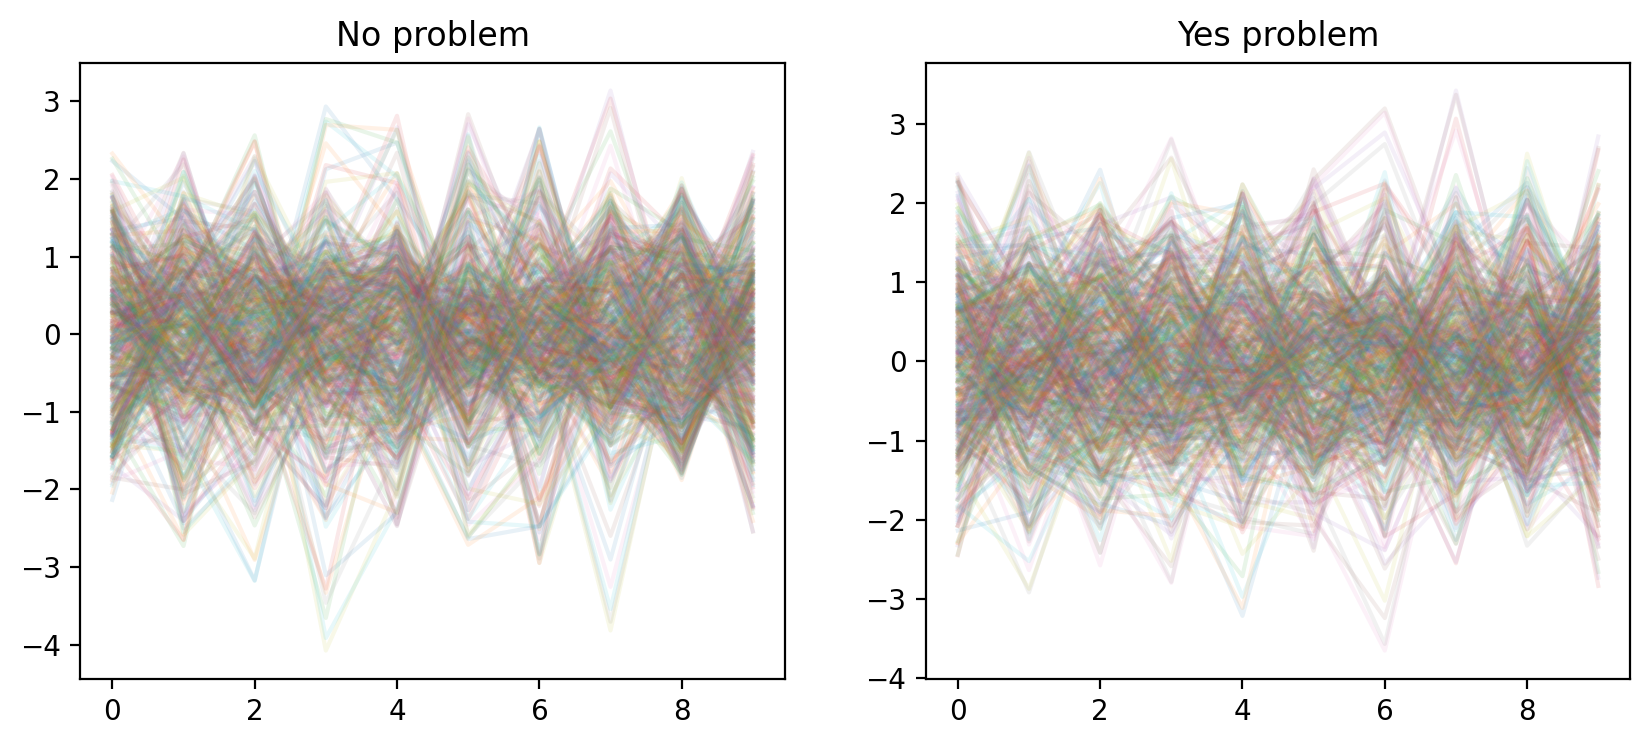

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x_ = x_train[y_train[:,0]==1]    
axes[0].plot(x_[:10], alpha=0.1)
axes[0].set_title("No problem")
x_ = x_train[y_train[:,1]==1]    
axes[1].plot(x_[:10], alpha=0.1)
axes[1].set_title("Yes problem");

# CNN classifier

Let's start with a simple model that we have seen before for images - a convolutional neural network. 
See details in [Wang et al. 2016](https://arxiv.org/abs/1611.06455).
We follow the example from the [Keras docs](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/).

In [36]:
model = keras.Sequential([
    keras.layers.Reshape((nfeatures, 1), input_shape=(sequence_length,)),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 500, 1)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 64)           256       
                                                                 
 batch_normalization_3 (Bat  (None, 500, 64)           256       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 500, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 500, 64)           12352     
                                                                 
 batch_normalization_4 (Bat  (None, 500, 64)           256       
 chNormalization)                                     

In [37]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=["accuracy"],
)

Let's run the training. 
We use two "callbacks":
- `ReduceLROnPlateau` reduces the learning rate when the validation loss stops decreasing for 20 epochs (validation loss is computed on 20% of the training data).
- `EarlyStopping` stops the training when the validation loss does not decrease for 50 epochs.

In [38]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]
)

Epoch 1/300
90/90 [==============================] - 7s 64ms/step - loss: 0.5871 - accuracy: 0.6753 - val_loss: 0.7474 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 2/300
90/90 [==============================] - 6s 66ms/step - loss: 0.4872 - accuracy: 0.7507 - val_loss: 0.8445 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 3/300
90/90 [==============================] - 6s 62ms/step - loss: 0.4553 - accuracy: 0.7799 - val_loss: 0.7272 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 4/300
90/90 [==============================] - 6s 63ms/step - loss: 0.4375 - accuracy: 0.7788 - val_loss: 0.9144 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 5/300
90/90 [==============================] - 6s 64ms/step - loss: 0.4122 - accuracy: 0.7986 - val_loss: 0.6825 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 6/300
90/90 [==============================] - 6s 68ms/step - loss: 0.4085 - accuracy: 0.7955 - val_loss: 0.5045 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 7/300
90/90 [==============================] - 7s 79ms/step - lo

In [46]:
model.save("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

Let's see how the CNN model performs on the test data.

In [40]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

113/113 [==============================] - 2s 19ms/step - loss: 0.0561 - accuracy: 0.9825
Test accuracy 0.9825048446655273
Test loss 0.05611295998096466


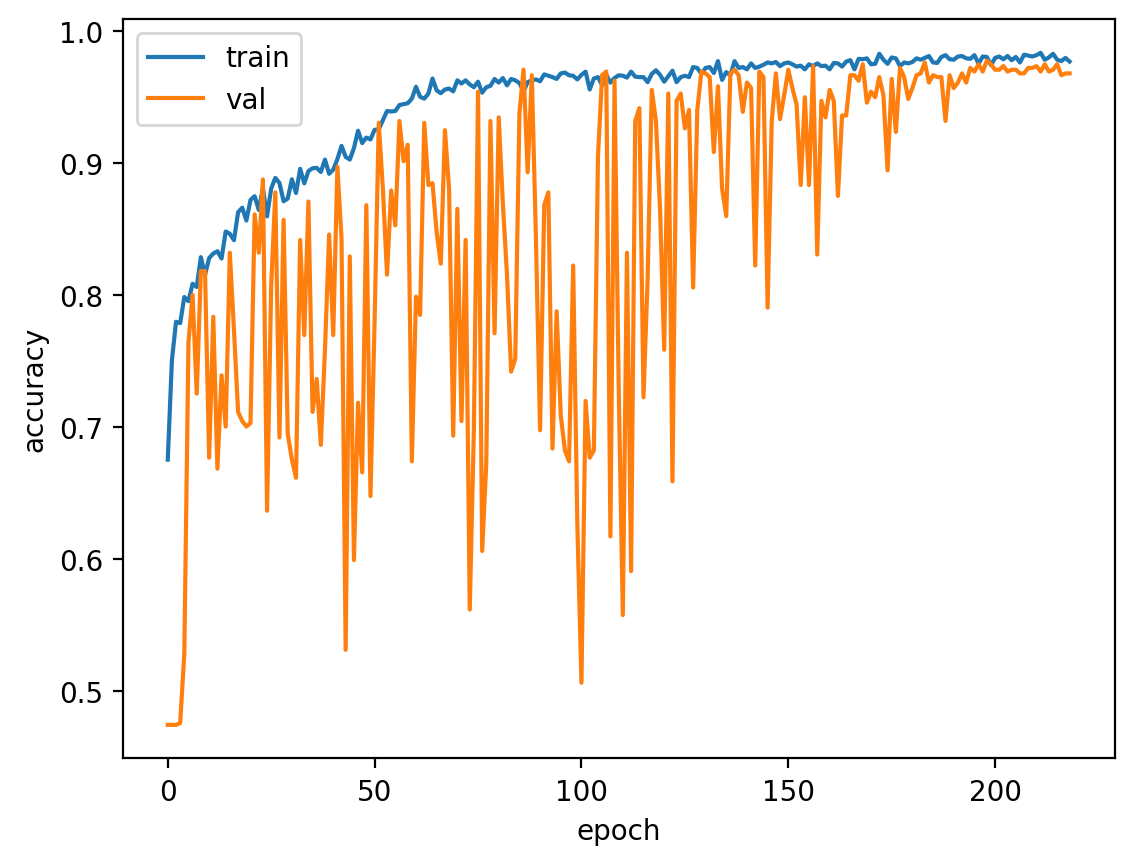

In [41]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"]);

We reached a high test accuracy - 98%. You can see that only in the last few epochs the validation accuracy stabilized.

# Transformer classifier

Our model has two parts: a transformer encoder, and a classifier.

The input to the transformer has shape `(batch size, sequence_length, features)`, where `sequence_length` is the number of time steps and `features` is each input timeseries, which in our case is just one.
This means that the transformer can replace an RNN: the inputs are fully compatible!
We include residual connections, layer normalization, and dropout. The resulting layer can be stacked multiple times.
The projection layers are implemented through a 1D convolution.

In [57]:
def transformer_encoder(input, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(input, input)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + input

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=input.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

Let's stack four transformer-encoders, and then connect them to a FFN classifier.

In [61]:
input = keras.Input(shape=(sequence_length,))
x = keras.layers.Reshape((sequence_length, 1))(input)

# stack four transformer-encoders
for _ in range(4):
    x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.25)
    
# feed-forward classifier
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(2, activation="softmax")(x)

model = keras.Model(input, output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 reshape_9 (Reshape)         (None, 500, 1)               0         ['input_9[0][0]']             
                                                                                                  
 multi_head_attention_16 (M  (None, 500, 1)               7169      ['reshape_9[0][0]',           
 ultiHeadAttention)                                                  'reshape_9[0][0]']           
                                                                                                  
 dropout_31 (Dropout)        (None, 500, 1)               0         ['multi_head_attention_1

In [62]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

In [ ]:
model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/150
45/45 [==============================] - 445s 10s/step - loss: 0.9249 - accuracy: 0.5146 - val_loss: 0.7492 - val_accuracy: 0.5465
Epoch 2/150
45/45 [==============================] - 428s 10s/step - loss: 0.7966 - accuracy: 0.5733 - val_loss: 0.6933 - val_accuracy: 0.5784
Epoch 3/150
45/45 [==============================] - 717s 16s/step - loss: 0.7507 - accuracy: 0.5830 - val_loss: 0.6661 - val_accuracy: 0.6144
Epoch 4/150
45/45 [==============================] - 3437s 78s/step - loss: 0.7091 - accuracy: 0.6184 - val_loss: 0.6469 - val_accuracy: 0.6380
Epoch 5/150
42/45 [===========================>..] - ETA: 40:41 - loss: 0.6910 - accuracy: 0.6362 

In [ ]:
model.save("../data/ford_transformer.keras")
with open("../data/ford_transformer_history.p", "wb") as f:
    pickle.dump(history, f)

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)